Example bootstrapped analysis of ReefMod results for Gabby Scheufele.

My R skills are very rusty so excuse anything obviously suboptimal!

In [1]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(ggplot2)

In [3]:
# Read data in skipping the first two columns (row id and "year_absolute")
cf_for_region2 = read.csv("data/cf_t_r2_2010.csv")

# Keep a copy of the years column for later use
years = cf_for_region2[, 2]

cf_for_region2 = cf_for_region2[, 3:ncol(cf_for_region2)]

in_for_region2 = read.csv("data/in_t_r2_2010.csv")
in_for_region2 = in_for_region2[, 3:ncol(in_for_region2)]

# Attach years as row names
row.names(cf_for_region2) = years
row.names(in_for_region2) = years

In [4]:
# Set a seed value for replicability
set.seed(101)

In [5]:

#' Bootstrap differences between dataframes of intervention and counterfactual
#' simulations.
#'
#' Note: Assumes DataFrames have years as row names!
#'
#' @param intervention A dataframe where rows are values for each year and
#'                     columns are values for each simulation.
#' @param counterfactual Same as `intervention` but for counterfactual sims
#' @param n_bootstraps Number of bootstrap samples to take. Defaults to 50.
#' @param n_resamples  Number of resamples to take per bootstrap.
#'                     Defaults to half the number of original samples.
#' @param ci The lower and upper bounds to estimate for bootstrapped confidence
#'        intervals. Defaults to 0.25 and 0.75 (i.e., 50% confidence interval)
#'
#' @returns A named list of dataframes
bootstrap_difference <- function(intervention, counterfactual, n_bootstraps, n_resamples=NA, ci=c(0.25,0.75)) {

    if (ncol(intervention) != ncol(counterfactual)) {
        stop("Number of samples in interventions do not match those in counterfactual dataset")
    }

    # Create dataframe to store results in
    years = row.names(intervention)  # use the attached row names to indicate years
    bootstrapped = data.frame(row.names=years)
    bootstrapped[, 1:ncol(intervention)] = rep(0, length(years))

    if (is.na(n_resamples)) {
        n_resamples = ceiling(ncol(intervention) / 2)
    }

    # Add unique column ids to dataframe
    sim_ids = 1:ncol(intervention)
    names(bootstrapped) = paste0("bt_", sim_ids)

    # Create copies for each summary stat of interest
    # Note: I'm sure there's an easier way of doing this
    #       but my R is very rusty...
    bootstrap_mean = data.frame(bootstrapped)
    bootstrap_median = data.frame(bootstrapped)
    bootstrap_lower = data.frame(bootstrapped)
    bootstrap_upper = data.frame(bootstrapped)

    # Temporary store for resamples
    means = data.frame(row.names=years)
    means[, 1:n_bootstraps] = rep(0, length(years))
    medians = data.frame(means)
    lowers = data.frame(means)
    uppers = data.frame(means)

    # For each original simulation, bootstrap the difference
    for (sim_id in 1:ncol(intervention)) {
        for (nb in 1:n_bootstraps) {
            # Sample column IDs to calculate differences with
            col_sample = sample(1:ncol(counterfactual), n_resamples, replace=TRUE)

            # Create corresponding bootstrap ID
            bt_id = paste0("bt_", sim_id)

            # Calculate the bootstrapped mean difference
            boot_diff = intervention[, col_sample] - counterfactual[, sim_id]
            means[, nb] = rowMeans(boot_diff)
            medians[, nb] = apply(boot_diff, 1, median)
            lowers[, nb] = apply(boot_diff, 1, function (x) quantile(x, ci[1]))
            uppers[, nb] = apply(boot_diff, 1, function (x) quantile(x, ci[2]))
        }

        # Calculate relevant summary stats
        bootstrap_mean[, bt_id] = rowMeans(means)
        bootstrap_median[, bt_id] = rowMeans(medians)
        bootstrap_lower[, bt_id] = rowMeans(lowers)
        bootstrap_upper[, bt_id] = rowMeans(uppers)
    }

    return(list(bt_mean=bootstrap_mean, bt_median=bootstrap_median, bt_lower=bootstrap_lower, bt_upper=bootstrap_upper))
}

In [6]:
boot_set = bootstrap_difference(in_for_region2, cf_for_region2, n_bootstraps=50)

In [7]:
# Could do several things here but I take the mean of the bootstrapped data
# to get an indication. This could be the mean, median or min/max for the
# confidence bounds. There are no hard rules as far as I know.
bt_summarized = data.frame(
    years=years,
    bt_mean_mean=rowMeans(boot_set$bt_mean),
    bt_mean_median=rowMeans(boot_set$bt_median),
    bt_mean_lower=rowMeans(boot_set$bt_lower),
    bt_mean_upper=rowMeans(boot_set$bt_upper)
)

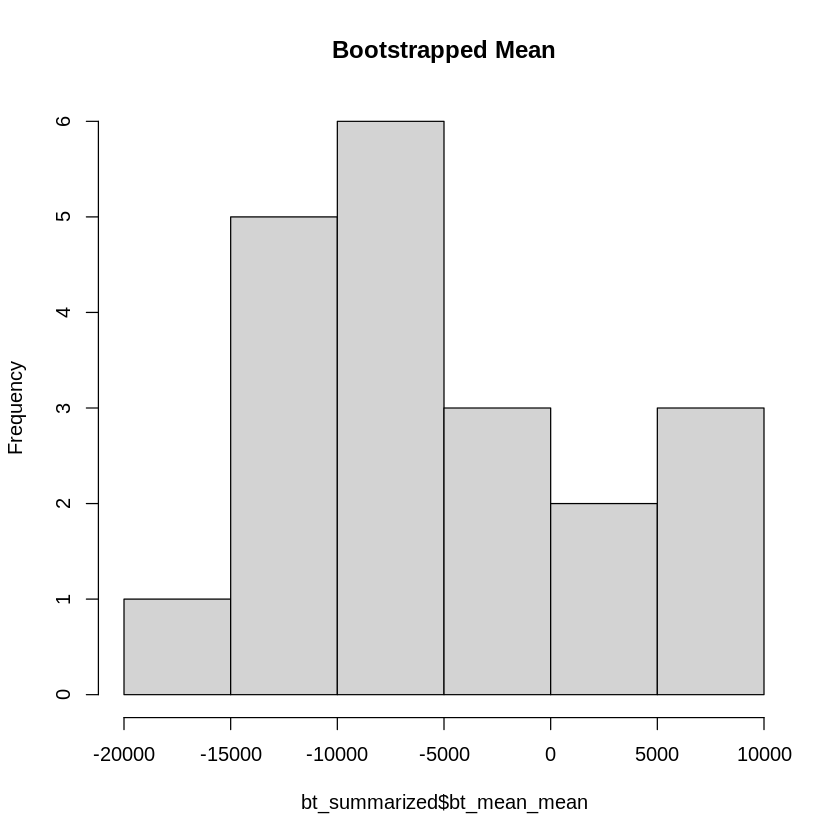

In [8]:
hist(bt_summarized$bt_mean_mean, main="Bootstrapped Mean")

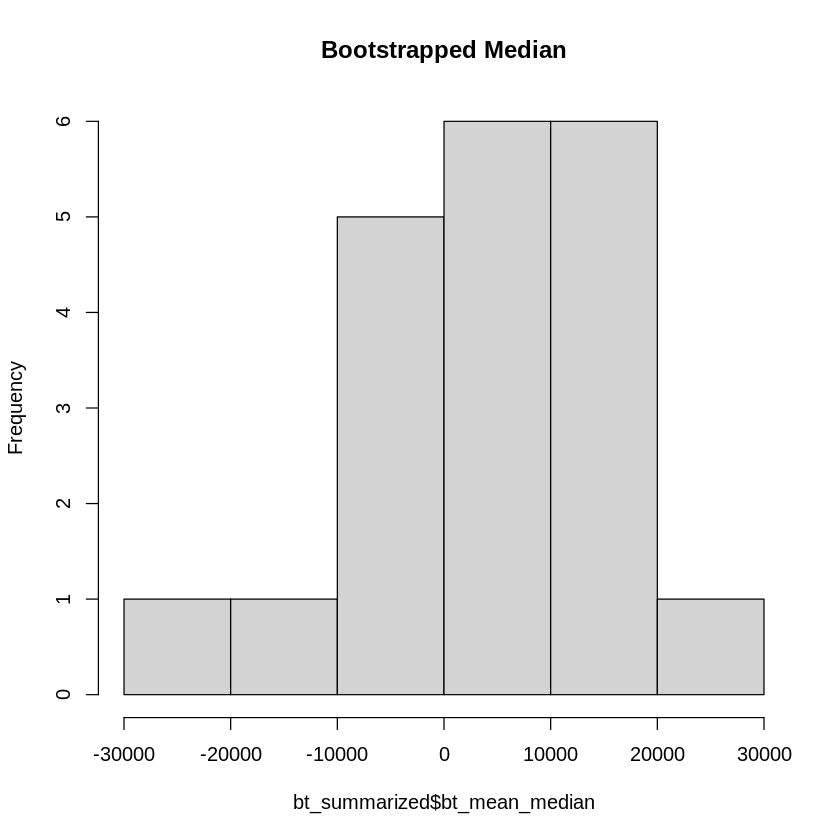

In [9]:
hist(bt_summarized$bt_mean_median, main="Bootstrapped Median")

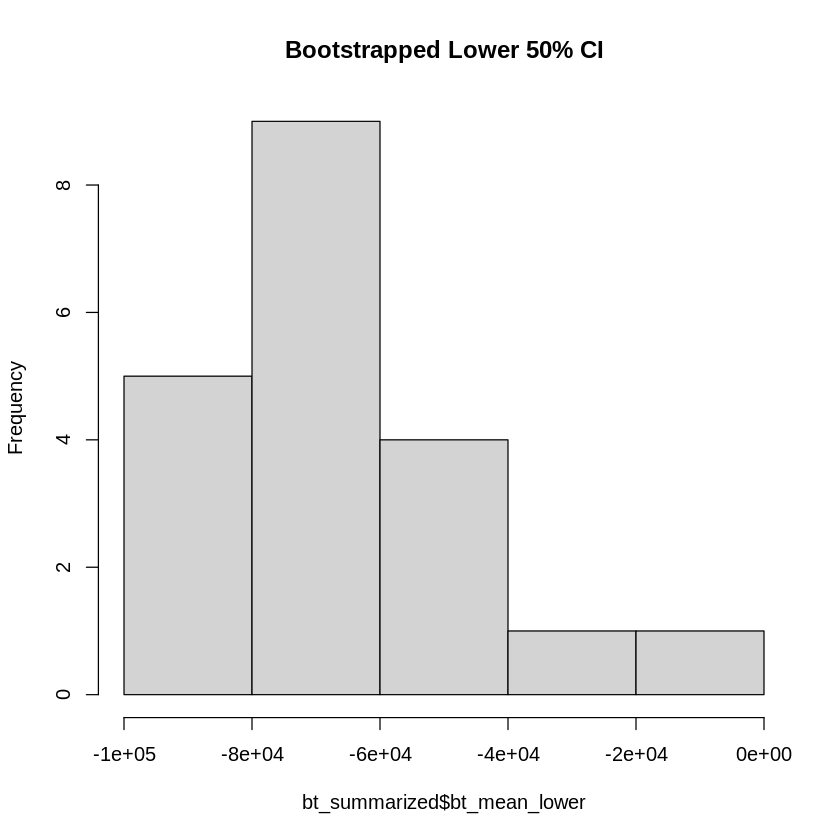

In [10]:
hist(bt_summarized$bt_mean_lower, main="Bootstrapped Lower 50% CI")

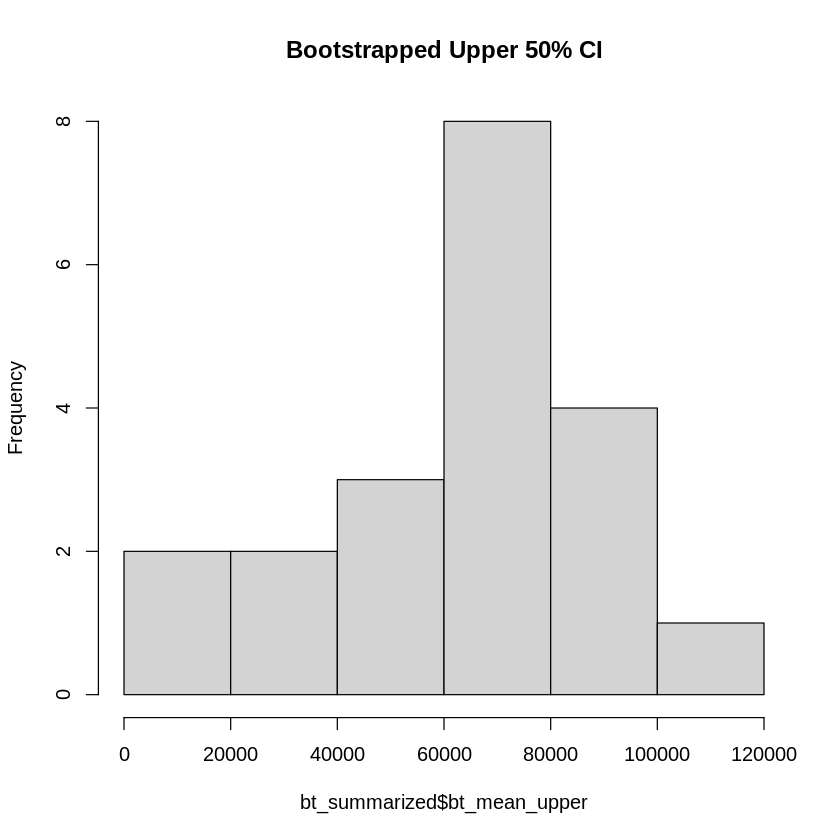

In [11]:
hist(bt_summarized$bt_mean_upper, main="Bootstrapped Upper 50% CI")

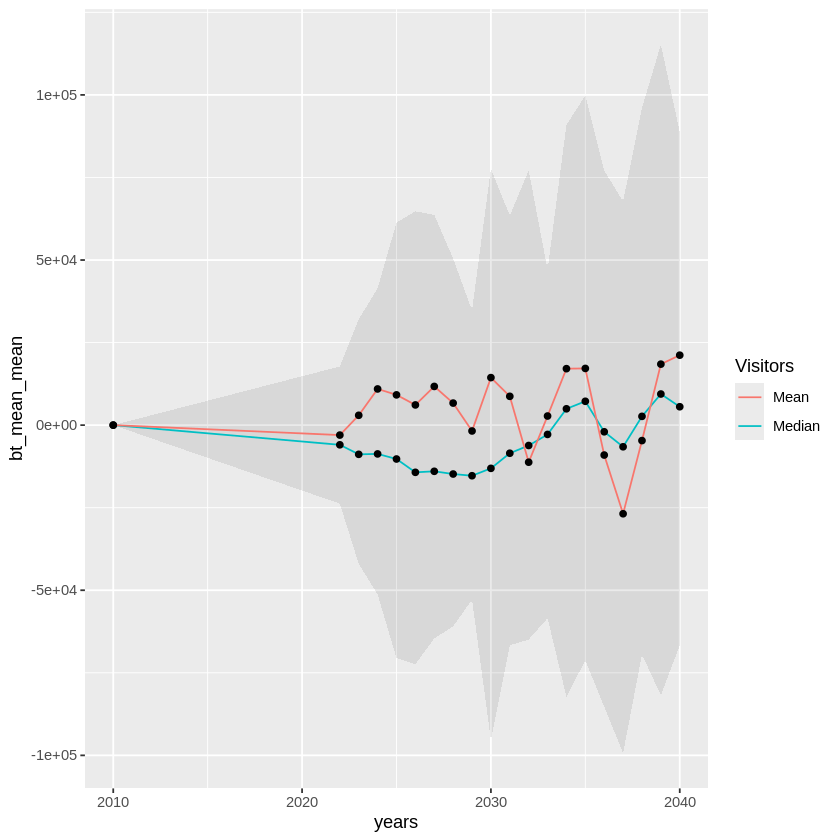

In [12]:
# Plot indication of uncertainty over time
# Note the greater uncertainty the further out in time you go
# which makes sense to me...
ggplot(bt_summarized, aes(x=years, ymin=bt_mean_lower, ymax=bt_mean_upper)) +
    geom_ribbon(alpha=0.1) +
    geom_line(aes(y=bt_mean_mean, color="green")) + geom_point(aes(y=bt_mean_mean)) +
    geom_line(aes(y=bt_mean_median, color="blue")) + geom_point(aes(y=bt_mean_median)) +
    scale_color_discrete(
        name="Visitors",
        labels=c("Mean","Median")
    )